# Телеком: исследование оттока клиентов

Задача проекта

Оператор связи «Ниединогоразрыва.ком» обнаружил отток клиентов и хочет взять ситуацию под контроль. Цель проекта научиться прогнозировать такие ситуации на основе данных о клиентах и ими выбранных услуг. 

In [ ]:
!pip install tabulate
!pip install phik
!pip install -U scikit-learn
!pip install catboost

     |████████████████████████████████| 709 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 30.8 MB 47 kB/s  eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [ ]:
import sklearn
sklearn.__version__

'1.1.2'

In [ ]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import phik
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from catboost import CatBoostClassifier, Pool
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, f1_score, roc_curve

In [ ]:
contract = pd.read_csv('/datasets/final_provider/contract.csv', decimal = ',')
internet = pd.read_csv('/datasets/final_provider/internet.csv', decimal = ',')
personal = pd.read_csv('/datasets/final_provider/personal.csv', decimal = ',')
phone = pd.read_csv('/datasets/final_provider/phone.csv', decimal = ',')

# contract = pd.read_csv('contract.csv', decimal = ',')
# internet = pd.read_csv('internet.csv', decimal = ',')
# personal = pd.read_csv('personal.csv', decimal = ',')
# phone = pd.read_csv('phone.csv', decimal = ',')

In [ ]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.7,151.65


In [ ]:
type(contract.EndDate.iloc[4])

str

In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   BeginDate         7043 non-null   object
 2   EndDate           7043 non-null   object
 3   Type              7043 non-null   object
 4   PaperlessBilling  7043 non-null   object
 5   PaymentMethod     7043 non-null   object
 6   MonthlyCharges    7043 non-null   object
 7   TotalCharges      7043 non-null   object
dtypes: object(8)
memory usage: 440.3+ KB


In [ ]:
contract['MonthlyCharges'] = contract['MonthlyCharges'].astype(float)
contract.loc[(contract.EndDate == 'No'), 'EndDate'] = '2020-02-01 00:00:00' # меняю пропущенные значения на дату изъятия данных
contract['EndDate'] = contract['EndDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
contract['BeginDate'] = contract['BeginDate'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [ ]:

contract_all = contract.copy()
contract_fnsh = contract[contract['EndDate'] != '2020-02-01 00:00:00']

print('колличество активных клиентов компании', contract_all['EndDate'].count())
print('колличество отключившихся клиентов компании', contract_fnsh['EndDate'].count())

колличество активных клиентов компании 7043
колличество отключившихся клиентов компании 1869


Достаточно много клиентов покинуло компанию (26,5%), с этим явно нужно что-то делать. Но есть и хорошая сторона - нам хватит данных для обучения предсказывающих моделей 

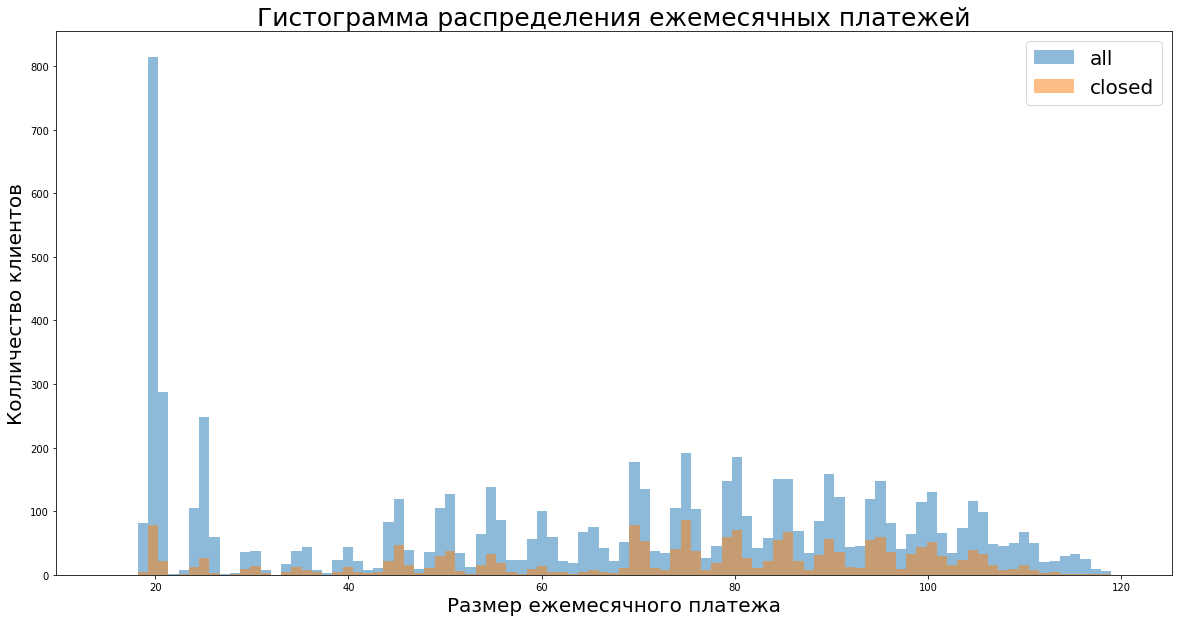

In [ ]:
bins = np.linspace(15, 120, 100)
plt.figure(figsize=(20, 10))
plt.xlabel('Размер ежемесячного платежа', fontsize=20)
plt.ylabel('Колличество клиентов', fontsize=20)
plt.title('Гистограмма распределения ежемесячных платежей', fontsize=25)

plt.hist(contract_all.MonthlyCharges, bins, alpha=0.5, label='all')
plt.hist(contract_fnsh.MonthlyCharges, bins, alpha=0.5, label='closed')
plt.legend(loc='upper right', fontsize=20)
plt.show()

Из графика видно, что большая часть ушедших клиентов платили более 70. Возможно им не нравилась цена услуг и они нашли более выгодное предложение. Соответственно наша группа риска в значительной мере расположена в диапазоне ежемесячных платежей от 70 до 110. Так же стоит заметить, что при минимальных платежах (20-25) ушли не более 10%. Местами колличество ушедших пользователей чуть меньше колличества оставшихся. Это наводит на мысль, что людям могут не нравиться конкретные продукты, входящие в комплекс услуг.

In [ ]:
describe_all = round(contract_all.MonthlyCharges.describe(), 2)
describe_fnsh = round(contract_fnsh.MonthlyCharges.describe(), 2)
d = [["mean", describe_all[1], describe_fnsh[1]],
     ["min", describe_all[3], describe_fnsh[3]],
     ["max", describe_all[7], describe_fnsh[7]],
     ["median", contract_all.MonthlyCharges.median(), contract_fnsh.MonthlyCharges.median()],
     ["25%", describe_all[4], describe_fnsh[4]],
     ["75%", describe_all[6], describe_fnsh[6]]]

print(tabulate(d, headers=["metric", "all clients", "departed clients"]))

metric      all clients    departed clients
--------  -------------  ------------------
mean              64.76               74.44
min               18.25               18.85
max              118.75              118.35
median            70.35               79.65
25%               35.5                56.15
75%               89.85               94.2


Примерно ту же картину показывает и статистика: медиана, среднее и 25% квантиль сильно сдвинуты вправо, в то время, как 75% квантиль сдвинут вправо гораздо меньше.

In [ ]:
# Создаю таблицы, где будут отмечены пользователи интернет и мобильных услуг, а так же их ежемесячные платежи.
cliets = contract[['customerID', 'EndDate', 'MonthlyCharges']]
cliets_i = cliets.merge(internet[['customerID', 'InternetService']], on = 'customerID', how = 'left')
cliets_p = cliets.merge(phone[['customerID', 'MultipleLines']], on = 'customerID', how = 'left')

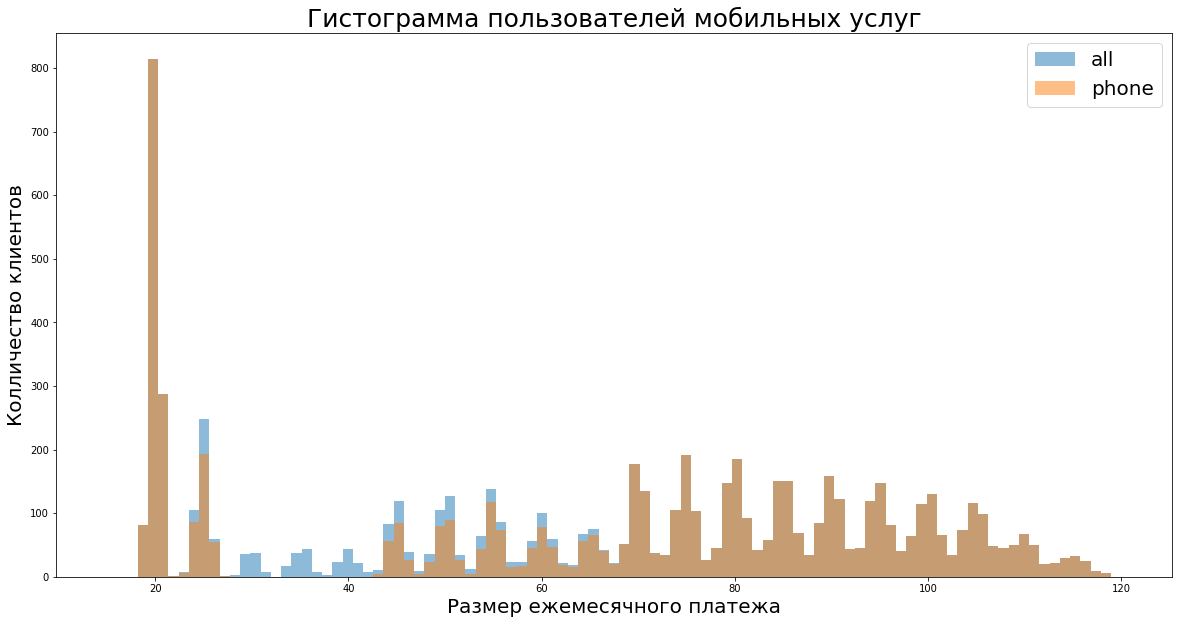

In [ ]:
df_phone_clients = cliets_p.dropna(subset = ['MultipleLines'])

bins = np.linspace(15, 120, 100)
plt.figure(figsize=(20, 10))
plt.xlabel('Размер ежемесячного платежа', fontsize=20)
plt.ylabel('Колличество клиентов', fontsize=20)
plt.title('Гистограмма пользователей мобильных услуг', fontsize=25)

plt.hist(contract.MonthlyCharges, bins, alpha=0.5, label='all')
plt.hist(df_phone_clients.MonthlyCharges, bins, alpha=0.5, label='phone')
plt.legend(loc='upper right', fontsize=20)
plt.show()

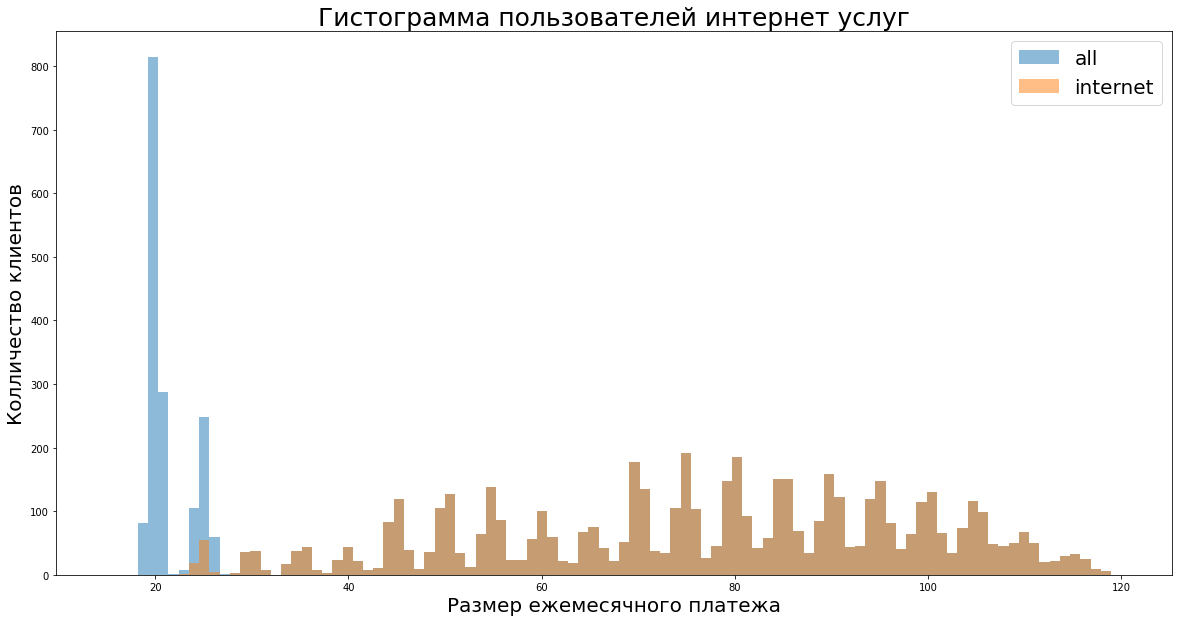

In [ ]:
df_inetnet_clients = cliets_i.dropna(subset = ['InternetService'])

bins = np.linspace(15, 120, 100)
plt.figure(figsize=(20, 10))
plt.xlabel('Размер ежемесячного платежа', fontsize=20)
plt.ylabel('Колличество клиентов', fontsize=20)
plt.title('Гистограмма пользователей интернет услуг', fontsize=25)

plt.hist(contract.MonthlyCharges, bins, alpha=0.5, label='all')
plt.hist(df_inetnet_clients.MonthlyCharges, bins, alpha=0.5, label='internet')
plt.legend(loc='upper right', fontsize=20)
plt.show()

Из графиков видно, что минимальный платеж не распространяется на интернет услуги. А так же то, что в зоне ежемесячных платежей от 40 до 120 мы видим примерно похожую картину. 

Дальнейший план действий:
1. Работа с данными
  * Исключить лишние данные
  * Привести оставшиеся к нужным типам
  * Подготовка выборок для обучения и тестирования
  * Сбалансировать классы
  * Нормировать данные

2. Обучение моделей (решающее дерево, случайный лес, GBM)
  * Подбор гиперпараметров
  * Обучение модели
  * Выбор наилучших гиперпараметров по метрике F1
        
3. Выбор лучшей модели
  * Кросс-валидация
  * Рекоммендации относительно доверия к предсказаниям.

Вопрос: С точки зрения стандартной классификации модель разделяет выборку на два четких класса (например собаки и кошки). В нашей же задаче класс ушедших клиентов предельно понятен, а вот среди оставшися есть те, кто уходить не собирается и те кто скоро уйдет. Значит мы не можем взять оставшихся клиентов за второй класс (остающихся в компании), ведь там содержатся признаки тех и других. Или можем? 

Мои мысли по этому вопросу: возможно правильнее прогнозировать не факт ухода клиента, а дату этого события.

In [ ]:
contract[pd.DatetimeIndex(contract['BeginDate']).year == 2013]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
975,2834-JRTUA,2013-11-01,2019-10-01,Two year,Yes,Electronic check,108.05,7532.15
3040,7317-GGVPB,2013-11-01,2019-10-01,Two year,Yes,Credit card (automatic),108.60,7690.9
3439,0917-EZOLA,2013-10-01,2019-10-01,Two year,Yes,Bank transfer (automatic),104.15,7689.95
4513,8580-QVLOC,2013-10-01,2019-10-01,Two year,No,Credit card (automatic),92.45,6440.25
4610,2889-FPWRM,2013-10-01,2019-10-01,One year,Yes,Bank transfer (automatic),117.80,8684.8
5441,3512-IZIKN,2013-12-01,2019-10-01,Two year,No,Credit card (automatic),65.30,4759.75
6038,1555-DJEQW,2013-12-01,2019-10-01,Two year,Yes,Bank transfer (automatic),114.20,7723.9
6290,2530-ENDWQ,2013-12-01,2019-11-01,Two year,Yes,Bank transfer (automatic),93.70,6585.35


In [ ]:
contract = contract[pd.DatetimeIndex(contract['BeginDate']).year != 2013]

In [ ]:
pd.to_datetime(contract['BeginDate']).dt.to_period('M')

0       2020-01
1       2017-04
2       2019-10
3       2016-05
4       2019-09
         ...   
7038    2018-02
7039    2014-02
7040    2019-03
7041    2019-07
7042    2014-08
Name: BeginDate, Length: 7035, dtype: period[M]

In [ ]:
contract = contract[pd.to_datetime(contract['BeginDate']).dt.to_period('M') != '2019-12']
contract = contract[pd.to_datetime(contract['BeginDate']).dt.to_period('M') != '2020-01']
contract = contract[pd.to_datetime(contract['BeginDate']).dt.to_period('M') != '2020-02']

In [ ]:
# создание целевого признака
contract['is active'] = 1
contract.loc[(contract.EndDate == '2020-02-01'), 'is active'] = 0

# расчет количества месяцев сотрудничества
contract['time active'] = contract['EndDate'] - contract['BeginDate']
contract['time active'] = (contract['time active'] / np.timedelta64(1, 'M')).astype(int)

# эти параметры потеряли смысл, их можно удалить
contract = contract.drop(['BeginDate'], axis=1)
contract = contract.drop(['EndDate'], axis=1)

In [ ]:
contract.head(10)

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,is active,time active
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.5,0,34
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,2
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,45
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,2
5,9305-CDSKC,Month-to-month,Yes,Electronic check,99.65,820.5,1,8
6,1452-KIOVK,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,0,22
7,6713-OKOMC,Month-to-month,No,Mailed check,29.75,301.9,0,10
8,7892-POOKP,Month-to-month,Yes,Electronic check,104.80,3046.05,1,28
9,6388-TABGU,One year,No,Bank transfer (automatic),56.15,3487.95,0,62
10,9763-GRSKD,Month-to-month,Yes,Mailed check,49.95,587.45,0,13


In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6571 entries, 1 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        6571 non-null   object 
 1   Type              6571 non-null   object 
 2   PaperlessBilling  6571 non-null   object 
 3   PaymentMethod     6571 non-null   object 
 4   MonthlyCharges    6571 non-null   float64
 5   TotalCharges      6571 non-null   object 
 6   is active         6571 non-null   int64  
 7   time active       6571 non-null   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 462.0+ KB


In [ ]:
# Собираю все данные в обну таблицу. Присоединяю слева к таблице контрактов, как к наиболее полной.
all_inf = contract.merge(internet, on = 'customerID', how = 'left')
all_inf = all_inf.merge(phone, on = 'customerID', how = 'left')
all_inf = all_inf.merge(personal, on = 'customerID', how = 'left')

In [ ]:
all_inf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6571 entries, 0 to 6570
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        6571 non-null   object 
 1   Type              6571 non-null   object 
 2   PaperlessBilling  6571 non-null   object 
 3   PaymentMethod     6571 non-null   object 
 4   MonthlyCharges    6571 non-null   float64
 5   TotalCharges      6571 non-null   object 
 6   is active         6571 non-null   int64  
 7   time active       6571 non-null   int64  
 8   InternetService   5218 non-null   object 
 9   OnlineSecurity    5218 non-null   object 
 10  OnlineBackup      5218 non-null   object 
 11  DeviceProtection  5218 non-null   object 
 12  TechSupport       5218 non-null   object 
 13  StreamingTV       5218 non-null   object 
 14  StreamingMovies   5218 non-null   object 
 15  MultipleLines     5924 non-null   object 
 16  gender            6571 non-null   object 


In [ ]:
# соидентификатор пользователя не поможет в предсказании, так какявляется уникатьным в большенстве случаев
test = all_inf.drop(['customerID'], axis=1)

interval columns not set, guessing: ['MonthlyCharges', 'is active', 'time active', 'SeniorCitizen']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable TotalCharges is large: 6296. Are you sure this is not an interval variable? Analysis for pairs of variables including TotalCharges can be slow.
  warnings.warn(


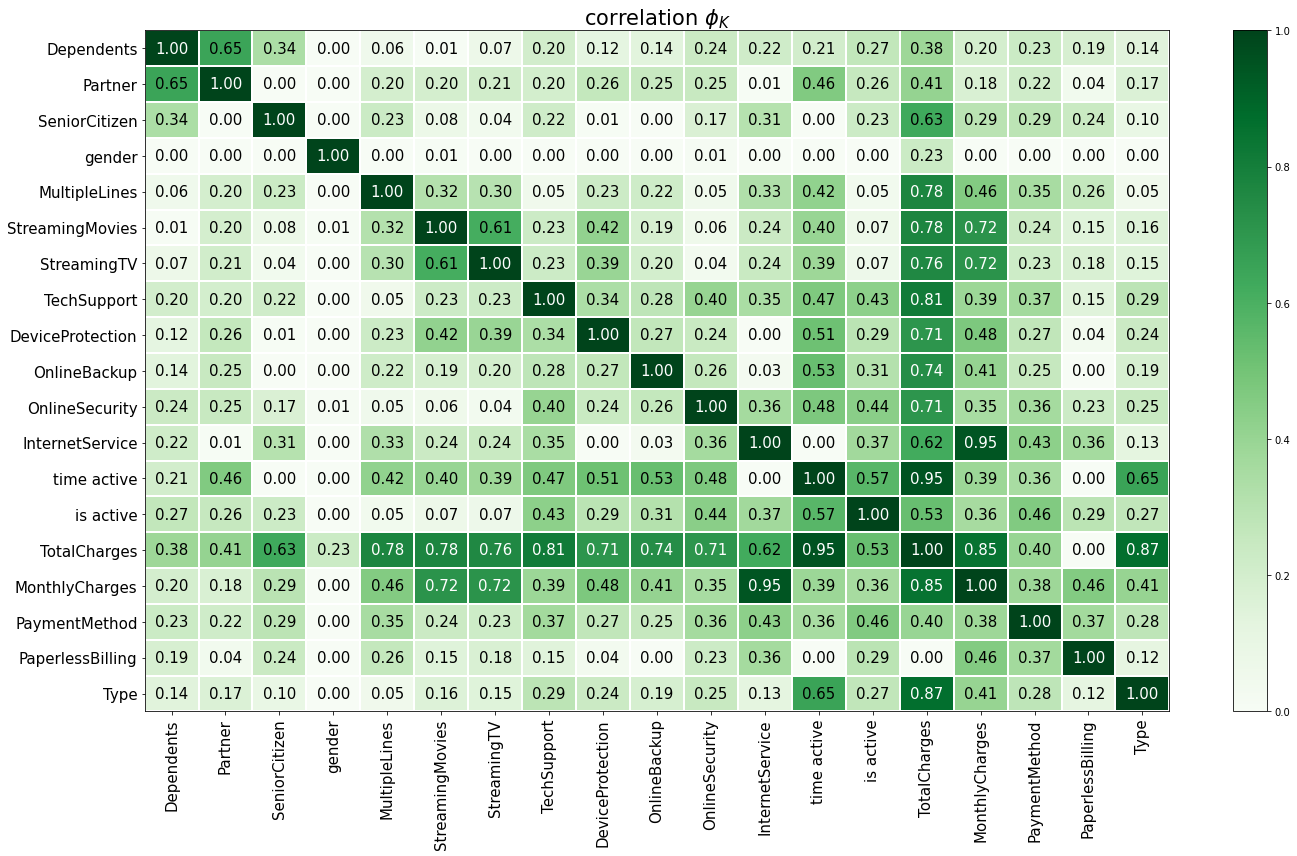

In [ ]:
phik_overview = test.phik_matrix()
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 12))
plt.tight_layout()

Первое, что бросается в глаза - TotalCharges. Этот параметр сильно коррелирует с другими, его стоит убрать. Чуть меньше зависимостей у столбца MonthlyCharges, но некоторые из них достаточно большие. Так же стоит посмотреть на глобальную корреляцию ниже. Из нее видно, что этот параметр 100% заменяемый за счет комбинации оставшихся. 
Известно, что дети чаще всего рождаются и живут в семьях, поэтому парметр Partner сильно зависит от Dependents.

interval columns not set, guessing: ['MonthlyCharges', 'is active', 'time active', 'SeniorCitizen']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable TotalCharges is large: 6296. Are you sure this is not an interval variable? Analysis for pairs of variables including TotalCharges can be slow.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/phik.py:319: RuntimeWarning: invalid value encountered in sqrt
  global_correlations = np.sqrt(


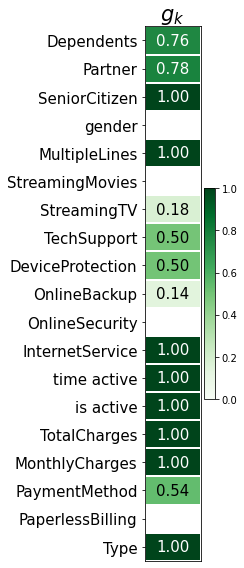

In [ ]:

global_correlation, global_labels = test.global_phik()

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(3.5,8),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()

interval columns not set, guessing: ['is active', 'time active', 'SeniorCitizen']


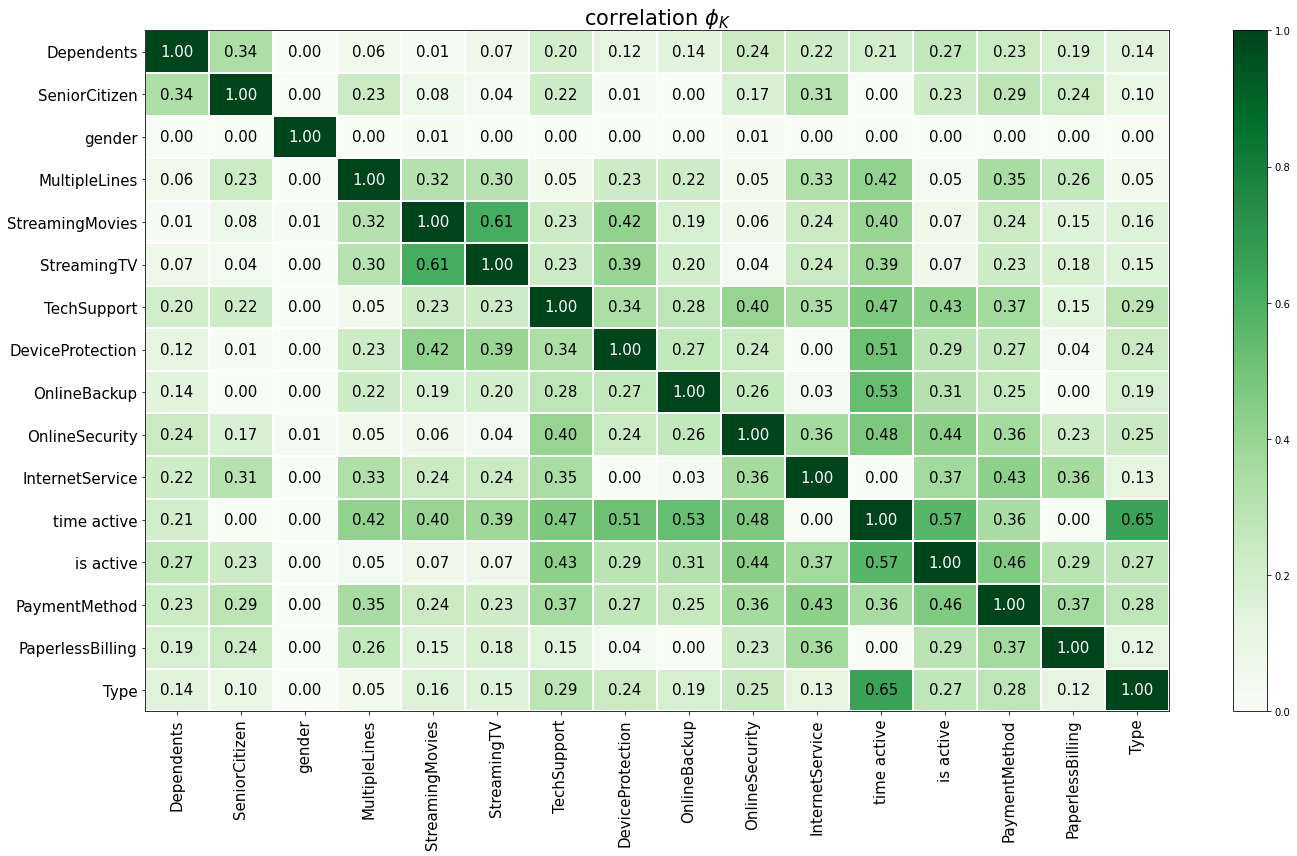

In [ ]:
test2 = all_inf.drop(['customerID', 'TotalCharges', 'MonthlyCharges', 'Partner'], axis=1)
phik_overview2 = test2.phik_matrix()
phik_overview2.round(2)

plot_correlation_matrix(phik_overview2.values, 
                        x_labels=phik_overview2.columns, 
                        y_labels=phik_overview2.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(20, 12))
plt.tight_layout()

практически все корреляции меньше 0.5, выделяется time_active, но тесты показали, что это достаточно важный параметр. А так же 0,63 у StreamingTV с StreamingMovies, но наличие этих столбцов не влияют на результаты

In [ ]:
test2 = test2.fillna('No')

**Подготовка выборок**

In [ ]:
target = test2['is active']
features = test2.drop(['is active', "gender", "MultipleLines", "StreamingMovies", "StreamingTV"] , axis=1)

raw_features_train, raw_features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=41022)

In [ ]:
raw_features_train = raw_features_train.fillna('Empty')
raw_features_valid = raw_features_valid.fillna('Empty')

In [ ]:
# преобразование строковых данных в числовые
categorical = ['Type', 'PaperlessBilling', 'PaymentMethod', 'OnlineSecurity', 
               'OnlineBackup', 'DeviceProtection', 'TechSupport',
               'Dependents', 'InternetService', 'SeniorCitizen']

encoder = OneHotEncoder(handle_unknown='error', drop='first')

#perform one-hot encoding 
encoded_train = pd.DataFrame(encoder.fit_transform(raw_features_train[categorical]).toarray())
encoded_train = encoded_train.set_index(raw_features_train.index)
encoded_train.columns = encoder.get_feature_names_out()

encoded_valid = pd.DataFrame(encoder.transform(raw_features_valid[categorical]).toarray())
encoded_valid = encoded_valid.set_index(raw_features_valid.index)
encoded_train.columns = encoder.get_feature_names_out()


print(raw_features_train.shape)
print(encoded_train.shape)

#merge one-hot encoded columns back with original DataFrame
features_train = pd.concat([raw_features_train, encoded_train], axis=1)
features_valid = pd.concat([raw_features_valid, encoded_valid], axis=1)

print(features_train.shape)

features_train.drop(categorical, axis=1, inplace=True)
features_valid.drop(categorical, axis=1, inplace=True)

print(features_train.shape)

features_train.columns = features_train.columns.astype(str)
features_valid.columns = features_valid.columns.astype(str)

(4928, 11)
(4928, 14)
(4928, 25)
(4928, 15)


In [ ]:
encoder.get_feature_names_out()

array(['Type_One year', 'Type_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'Dependents_Yes', 'InternetService_Fiber optic',
       'InternetService_No', 'SeniorCitizen_1'], dtype=object)

In [ ]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4928 entries, 2512 to 765
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   time active                            4928 non-null   int64  
 1   Type_One year                          4928 non-null   float64
 2   Type_Two year                          4928 non-null   float64
 3   PaperlessBilling_Yes                   4928 non-null   float64
 4   PaymentMethod_Credit card (automatic)  4928 non-null   float64
 5   PaymentMethod_Electronic check         4928 non-null   float64
 6   PaymentMethod_Mailed check             4928 non-null   float64
 7   OnlineSecurity_Yes                     4928 non-null   float64
 8   OnlineBackup_Yes                       4928 non-null   float64
 9   DeviceProtection_Yes                   4928 non-null   float64
 10  TechSupport_Yes                        4928 non-null   float64
 11  De

In [ ]:
features_train.head()

,time active,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,SeniorCitizen_1
2512,71,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
467,20,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
607,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
5056,38,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4852,36,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
features_train.describe()

,time active,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,SeniorCitizen_1
count,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000
mean,34.445008,0.222403,0.255885,0.597200,0.230114,0.337459,0.206575,0.298498,0.363028,0.361201,0.304383,0.312094,0.452110,0.205966,0.161526
std,23.824272,0.415902,0.436402,0.490511,0.420948,0.472891,0.404889,0.457646,0.480922,0.480397,0.460192,0.463395,0.497752,0.404447,0.368053
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,32.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,57.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,71.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# нормализация
numerical = ["time active"]
scaler = StandardScaler()
features_train[numerical] = scaler.fit_transform(features_train[numerical])
features_valid[numerical] = scaler.transform(features_valid[numerical])

In [ ]:
features_train.describe()

,time active,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_No,SeniorCitizen_1
count,4.928000e+03,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000,4928.000000
mean,3.604620e-17,0.222403,0.255885,0.597200,0.230114,0.337459,0.206575,0.298498,0.363028,0.361201,0.304383,0.312094,0.452110,0.205966,0.161526
std,1.000101e+00,0.415902,0.436402,0.490511,0.420948,0.472891,0.404889,0.457646,0.480922,0.480397,0.460192,0.463395,0.497752,0.404447,0.368053
min,-1.445942e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-9.841807e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.026372e-01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.468193e-01,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.534515e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Обучение моделей и подбор гиперпараметров**

In [ ]:
hiperpar = {"solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"], 
            'C': np.arange(0.1, 2, 0.1)}
model_lin = GridSearchCV(LogisticRegression(random_state=41022), hiperpar, cv = 3)
model_lin.fit(features_train.values, target_train)
print(model_lin.best_params_)
print(model_lin.best_score_)

{'C': 0.1, 'solver': 'liblinear'}
0.8110790768498551


In [ ]:
# DecisionTreeClassifier
# подбор гиперпараметров

hiperpar = {'max_depth': range(1, 50, 1), 'min_samples_leaf': range(1, 15, 1), }
model_tree = GridSearchCV(DecisionTreeClassifier(random_state=41022, class_weight = 'balanced'), hiperpar, cv = 3)
model_tree.fit(features_train.values, target_train)
print(model_tree.best_params_)
print(model_tree.best_score_)

{'max_depth': 6, 'min_samples_leaf': 14}
0.7792201020631827


In [ ]:
# RandomForestClassifier
# подбор гиперпараметров

hiperpar = {'n_estimators': range(50, 500, 10)}
model_forest = GridSearchCV(RandomForestClassifier(random_state=41022, class_weight = 'balanced'), hiperpar, cv = 3)
model_forest.fit(features_train.values, target_train)
print(model_forest.best_params_)
print(model_forest.best_score_)

{'n_estimators': 320}
0.8037730165425782


In [ ]:
# GradientBoostingClassifier
# подбор гиперпараметров

hiperpar = {
    'n_estimators': range(10, 500, 10)
}

model_gbc = GridSearchCV(GradientBoostingClassifier(random_state=41022), hiperpar, cv = 3)
model_gbc.fit(features_train.values, target_train)
print(model_gbc.best_params_)
print(model_gbc.best_score_)

{'n_estimators': 140}
0.8380653266642103


In [ ]:
#Код ревюера
catboost = CatBoostClassifier(loss_function='Logloss', cat_features=categorical, random_seed=41022,silent=True)

catboost_params = {
 'depth': [x for x in range(1,3)],
 'iterations': [x for x in range(250,1000, 250)],
 'learning_rate': [0.3,0.4,0.5],
 'l2_leaf_reg':[x for x in range(1,3)]
}

grid_search_catboost = GridSearchCV(catboost,
                                   catboost_params, 
                                   verbose=3,
                                   cv=5,
                                   n_jobs=-1,
                                   scoring='roc_auc')


grid_search_catboost.fit(raw_features_train, target_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END depth=1, iterations=250, l2_leaf_reg=1, learning_rate=0.3;, score=0.895 total time=   0.9s
[CV 2/5] END depth=1, iterations=250, l2_leaf_reg=1, learning_rate=0.3;, score=0.887 total time=   0.9s
[CV 3/5] END depth=1, iterations=250, l2_leaf_reg=1, learning_rate=0.3;, score=0.875 total time=   0.9s
[CV 4/5] END depth=1, iterations=250, l2_leaf_reg=1, learning_rate=0.3;, score=0.887 total time=   0.8s
[CV 5/5] END depth=1, iterations=250, l2_leaf_reg=1, learning_rate=0.3;, score=0.865 total time=   0.9s
[CV 1/5] END depth=1, iterations=250, l2_leaf_reg=1, learning_rate=0.4;, score=0.895 total time=   0.8s
[CV 2/5] END depth=1, iterations=250, l2_leaf_reg=1, learning_rate=0.4;, score=0.888 total time=   0.8s
[CV 3/5] END depth=1, iterations=250, l2_leaf_reg=1, learning_rate=0.4;, score=0.876 total time=   0.8s
[CV 4/5] END depth=1, iterations=250, l2_leaf_reg=1, learning_rate=0.4;, score=0.889 total time=   0.8s
[C

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f9eb9d65280>,
             n_jobs=-1,
             param_grid={'depth': [1, 2], 'iterations': [250, 500, 750],
                         'l2_leaf_reg': [1, 2],
                         'learning_rate': [0.3, 0.4, 0.5]},
             scoring='roc_auc', verbose=3)

In [ ]:
print(grid_search_catboost.get_params)
print(grid_search_catboost.best_score_)

<bound method BaseEstimator.get_params of GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7f9eb9d65280>,
             n_jobs=-1,
             param_grid={'depth': [1, 2], 'iterations': [250, 500, 750],
                         'l2_leaf_reg': [1, 2],
                         'learning_rate': [0.3, 0.4, 0.5]},
             scoring='roc_auc', verbose=3)>
0.8849162079979737


In [ ]:
xgb_cl = xgb.XGBClassifier(random_state=41022)
xgb_cl.fit(features_train.values, target_train)

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=41022,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
# LGBM
# подбор гиперпараметров

hiperpar = {
    'n_estimators': range(50, 200, 20),
    'learning_rate': np.arange(0.005,0.1,0.02),
#     "max_depth": range(1,5,1)
}

model_lgbm = GridSearchCV(lgb.LGBMClassifier(random_state=41022), hiperpar, cv = 3)
model_lgbm.fit(features_train.values, target_train)
print(model_lgbm.best_params_)
print(model_lgbm.best_score_)

{'learning_rate': 0.085, 'n_estimators': 50}
0.8258909894435206


In [ ]:
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(random_state=41022, shuffle=True)
cross_val_score_lin  = cross_val_score(model_lin,  features_train.values, target_train, cv=cv, scoring='roc_auc')
cross_val_score_tree = cross_val_score(model_tree, features_train.values, target_train, cv=cv, scoring='roc_auc')
cross_val_score_gbc  = cross_val_score(model_gbc,  features_train.values, target_train, cv=cv, scoring='roc_auc')
cross_val_score_cat  = cross_val_score(model,      features_train.values, target_train, cv=cv, scoring='roc_auc')
cross_val_score_xgb  = cross_val_score(xgb_cl,     features_train.values, target_train, cv=cv, scoring='roc_auc')
cross_val_score_lgbm = cross_val_score(model_lgbm, features_train.values, target_train, cv=cv, scoring='roc_auc')

In [ ]:
print('кросс-валидация логистической регрессии модели:', cross_val_score_lin.mean())
print('кросс-валидация решающего дерева модели:', cross_val_score_tree.mean())
print('кросс-валидация градиентного бустинга модели:', cross_val_score_gbc.mean())
print('кросс-валидация кат бустинга модели:', cross_val_score_cat.mean())
print('кросс-валидация xgb модели:', cross_val_score_xgb.mean())
print('кросс-валидация lgbm модели:', cross_val_score_lgbm.mean())

In [ ]:
len(np.where(target_train == 1)[0])/len(target_train)
len(np.where(target_train == 0)[0])/len(target_train)

In [ ]:
# explicitly require this experimental feature
from sklearn.experimental import enable_halving_search_cv # noqa
# now you can import normally from model_selection
from sklearn.model_selection import HalvingGridSearchCV# GradientBoostingClassifier
# подбор гиперпараметров

hiperpar = {
    'n_estimators': range(450, 700, 50),
    'learning_rate': np.arange(0.1,0.3,0.05),
    "min_samples_split": range(2500,3000,100),
    "min_samples_leaf": range(30,45,5),
    "max_depth": range(4,8,2)
}
model_gbc = HalvingGridSearchCV(GradientBoostingClassifier(random_state=41022), hiperpar, cv = cv)
model_gbc.fit(features_train.values, target_train)
print(model_gbc.best_params_)
print(model_gbc.best_score_)

In [ ]:
{'learning_rate': 0.2, 'max_depth': 6, 'min_samples_leaf': 40, 'min_samples_split': 2500, 'n_estimators': 650}

# Тестирование лучшей модели

In [ ]:
#Код ревьюера
model_ctb = CatBoostClassifier(**grid_search_catboost.best_params_, cat_features=categorical)
model_ctb.fit(raw_features_train, target_train)

0:	learn: 0.5543873	total: 2.56ms	remaining: 1.92s
1:	learn: 0.4892945	total: 5.63ms	remaining: 2.1s
2:	learn: 0.4420379	total: 7.76ms	remaining: 1.93s
3:	learn: 0.4039992	total: 9.94ms	remaining: 1.85s
4:	learn: 0.3930231	total: 12.1ms	remaining: 1.8s
5:	learn: 0.3882314	total: 14.1ms	remaining: 1.75s
6:	learn: 0.3830708	total: 16.1ms	remaining: 1.71s
7:	learn: 0.3807994	total: 18.1ms	remaining: 1.67s
8:	learn: 0.3771340	total: 20.2ms	remaining: 1.66s
9:	learn: 0.3735760	total: 22.3ms	remaining: 1.65s
10:	learn: 0.3722048	total: 24.4ms	remaining: 1.64s
11:	learn: 0.3709439	total: 26.5ms	remaining: 1.63s
12:	learn: 0.3700761	total: 28.7ms	remaining: 1.62s
13:	learn: 0.3688404	total: 31.1ms	remaining: 1.64s
14:	learn: 0.3685905	total: 33.4ms	remaining: 1.64s
15:	learn: 0.3681538	total: 35.5ms	remaining: 1.63s
16:	learn: 0.3674690	total: 37.5ms	remaining: 1.62s
17:	learn: 0.3662553	total: 39.6ms	remaining: 1.61s
18:	learn: 0.3662339	total: 41.6ms	remaining: 1.6s
19:	learn: 0.3636922	tota

In [ ]:
#Код ревьюера
predict_proba = model_ctb.predict_proba(raw_features_valid)[:, 1]
print('метрика roc_auc', roc_auc_score(target_valid, predict_proba))

метрика roc_auc 0.8703934094845712


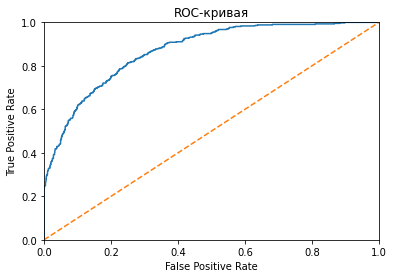

In [ ]:
fpr, tpr, thresholds = roc_curve(target_valid, predict_proba)

plt.figure()

plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')

# < примените функции plt.xlim() и plt.ylim(), чтобы
#   установить границы осей от 0 до 1 >
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

# < примените функции plt.xlabel() и plt.ylabel(), чтобы
#   подписать оси "False Positive Rate" и "True Positive Rate" >
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
# < добавьте к графику заголовок "ROC-кривая" функцией plt.title() >

plt.show()

Text(0.5, 1.0, 'Feature Importance (MDI)')

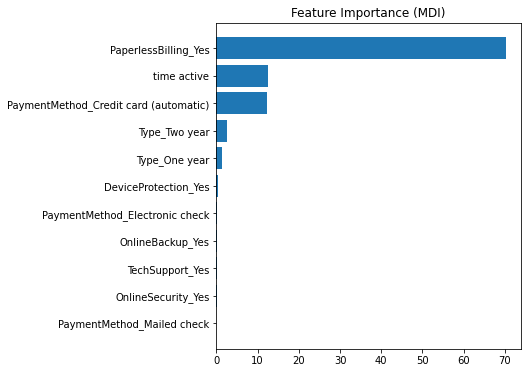

In [ ]:
feature_importance = model_ctb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(features_train.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

На основе кросс валидации с 5 частями было установлено, что модель CatBoost обладает самой лучшей предсказательной способностью на данном датасете. В ходе экспериментов было получено качество roc-auc 0.87 на отложенной выборке.

Анализ важности признаков показывает, что наибольшим вкладом в предсказание могут обладать признаки time_active (чем дольше сотрудничество с клиентом, тем менее вероятен уход), а также факт выставления счёта на электронную почту и оплата картой.




Итог: у меня получилось обработать данные, применяя навыки, полученные при обучении. Некоторые из параметров я решила удалить, основываясь на логике и корреляции между ними. Балансировка классов выполнялась при обучении моделей, а не при подготовке выборок, как планировала ранее. Из-за неудовлетворившего меня качества обучения моделей, попробовола гораздо больше, чем прописала в плане, но желаемого ревультата получить не смогла. Хотя достаточно странно видеть самые простые модели с наилучшими результатами.